# Decompose a Molecule In a Tree Structure Using Recap in RDKit

*[Download this notebook from GitHub by right-clicking and choosing Save Link As...](https://raw.githubusercontent.com/bertiewooster/bertiewooster.github.io/main/_notebooks/2022-10-09-RDKit-find-and-highlight-the-maximum-common-substructure-between-molecules.ipynb)*

*Update to correct link*

Decomposing a molecule into a set of fragments that could be combined to make the parent molecule using common reactions is a useful transformation. The [Recap algorithm](https://www.semanticscholar.org/paper/RECAP-%E2%80%94-Retrosynthetic-Combinatorial-Analysis-A-New-Lewell-Judd/fbfb10d1f63aa803f6d47df6587aa0e41109f5ee) by X. Lewell, D. Judd, S. Watson, and M. Hann accomplishes that. [Recap is implemented in RDKit](https://www.rdkit.org/docs/GettingStartedInPython.html#recap-implementation) cheminformatics Python package].

RDKit helpfully provides a hierarchical structure of nodes, where the keys are SMILES strings corresponding to the fragment, and the values are nodes containing child fragments. However, it is not easy to visualize the results, because the results are SMILES strings and the hierarchy is not shown visually:

In [9]:
from rdkit import Chem
from rdkit.Chem import Draw, Recap

In [10]:
molecule = Chem.MolFromSmiles("n1c(OCO)cccc1-OCO")
hierarch = Recap.RecapDecompose(molecule)
ks=hierarch.children.keys()
sorted(ks)

['*CO', '*c1cccc(OCO)n1']

This utility function `molecule_recap_tree` allows you to visualize both the fragments and their hierarchy. Here is an example, of 6-(Hydroxymethoxy)pyridin-2-yl]oxymethanol:

In [11]:
def molecule_recap_tree(smiles:str, name:str="", **kwargs):
    molecule = Chem.MolFromSmiles(smiles)
    hierarch = Recap.RecapDecompose(molecule)
    root = NonBinTree(hierarch.smiles)
    molecule_tree = get_children(hierarch, root)
    recap_2D = molecule_tree.get_grid()
    mols_per_row = len(recap_2D[0])
    recap_plot = [item for sublist in recap_2D for item in sublist]
    recap_labels = [item for sublist in recap_2D for item in sublist]
    if name:
        recap_labels[0] = name
    else:
        recap_labels[0] = hierarch.smiles
    drawing = Draw.MolsToGridImage([Chem.MolFromSmiles(smile) for smile in recap_plot], legends=recap_labels, molsPerRow=mols_per_row, **kwargs)
    return drawing

In [12]:
def concat(grid1, grid2):
    if grid1 == [[]]:
        combined = grid2
    elif grid2 == [[]]:
        combined = grid1
    else:
        combined = []
        for row_counter in range(len(grid1)):
            combined += [grid1[row_counter] + grid2[row_counter]]
    return combined

class NonBinTree:
    """Adapted from https://stackoverflow.com/questions/60579330/non-binary-tree-data-structure-in-python#60579464"""

    def __init__(self, val):
        self.val = val
        self.nodes = []

    def add_node(self, val):
        self.nodes.append(NonBinTree(val))
        return self.nodes[-1]

    def __repr__(self):
        return f"NonBinTree({self.val}): {self.nodes}"

    def get_ncols(self):
        self.ncols = 0
        if len(self.nodes) > 0:
            # If there are nodes under this one, call get_ncols on them recursively
            for node in self.nodes:
                self.ncols += node.get_ncols()
        else:
            # If there are no nodes under this one, add 1 for this node
            self.ncols += 1
        return self.ncols

    def get_max_depth(self):
        max_depth = 0
        if len(self.nodes) > 0:
            for node in self.nodes:
                this_depth = node.get_max_depth()
                max_depth = max(this_depth + 1, max_depth)
        else:
            max_depth = max(1, max_depth)
        self.max_depth = max_depth
        return self.max_depth

    def get_grid(self):
        # Call methods to calculate ncols and max_depth
        self.get_ncols()
        self.get_max_depth()

        # Create top row: Node value, then the rest of columns are blank (empty strings)
        grid = [[self.val] + [""] * (self.ncols - 1)]

        n_nodes = len(self.nodes)
        if n_nodes > 0:
            nodes_grid = [[]]
            for node_counter, node in enumerate(self.nodes):
                node_grid = node.get_grid()

                # Add spacer rows if needed
                node_grid_rows = len(node_grid)
                rows_padding = self.max_depth - node_grid_rows - 1
                for padding in range(rows_padding):
                    node_grid += [[""] * len(node_grid[0])]

                nodes_grid = concat(nodes_grid, node_grid)

            grid += nodes_grid

        return grid

In [13]:
def get_children(base_node: Chem.Recap.RecapHierarchyNode, root:NonBinTree = None, level:int=0):
    # root = NonBinTree("base_node")
    for smiles, node in base_node.children.items():
        added_tree_node = root.add_node(smiles)
        # spaces = " " * level
        # print(f"{spaces}{smiles}")
        children = node.children.keys()
        children = sorted(children)
        if len(children) > 0:
            get_children(node, added_tree_node, level + 1)
    return root

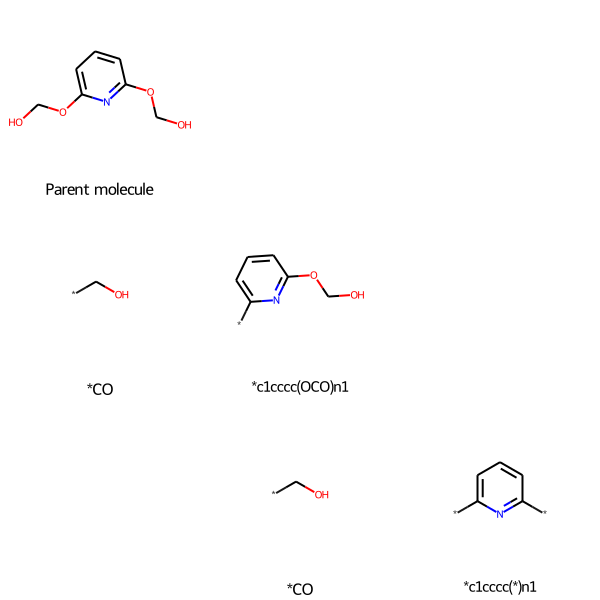

In [14]:
molecule_recap_tree("n1c(OCO)cccc1-OCO", "Parent molecule")

The key RDKit commands it uses are:
- [`FindMCS`](https://www.rdkit.org/docs/source/rdkit.Chem.rdFMCS.html) to find the maximum common substructure (SMARTS string)
- [`MolFromSmarts`](https://www.rdkit.org/docs/source/rdkit.Chem.rdmolfiles.html) to generate a molecule corresponding to the maximum common substructure
- [`GenerateDepictionMatching2DStructure`](http://rdkit.org/docs/source/rdkit.Chem.rdDepictor.html) to align the matching substructure
- [`MolsToGridImage`](https://www.rdkit.org/docs/source/rdkit.Chem.Draw.html) to draw the fragment hierarchy in a grid, and label the fragments with their SMILES strings

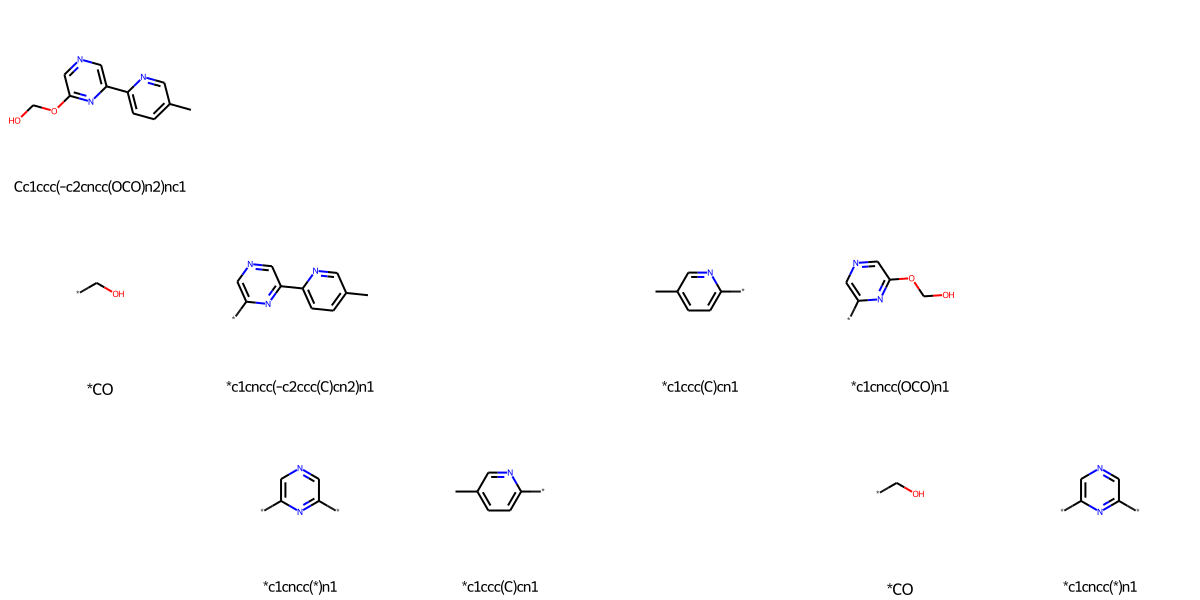

In [15]:
molecule_recap_tree("n1c(OCO)cncc1-c2ccc(C)cn2")

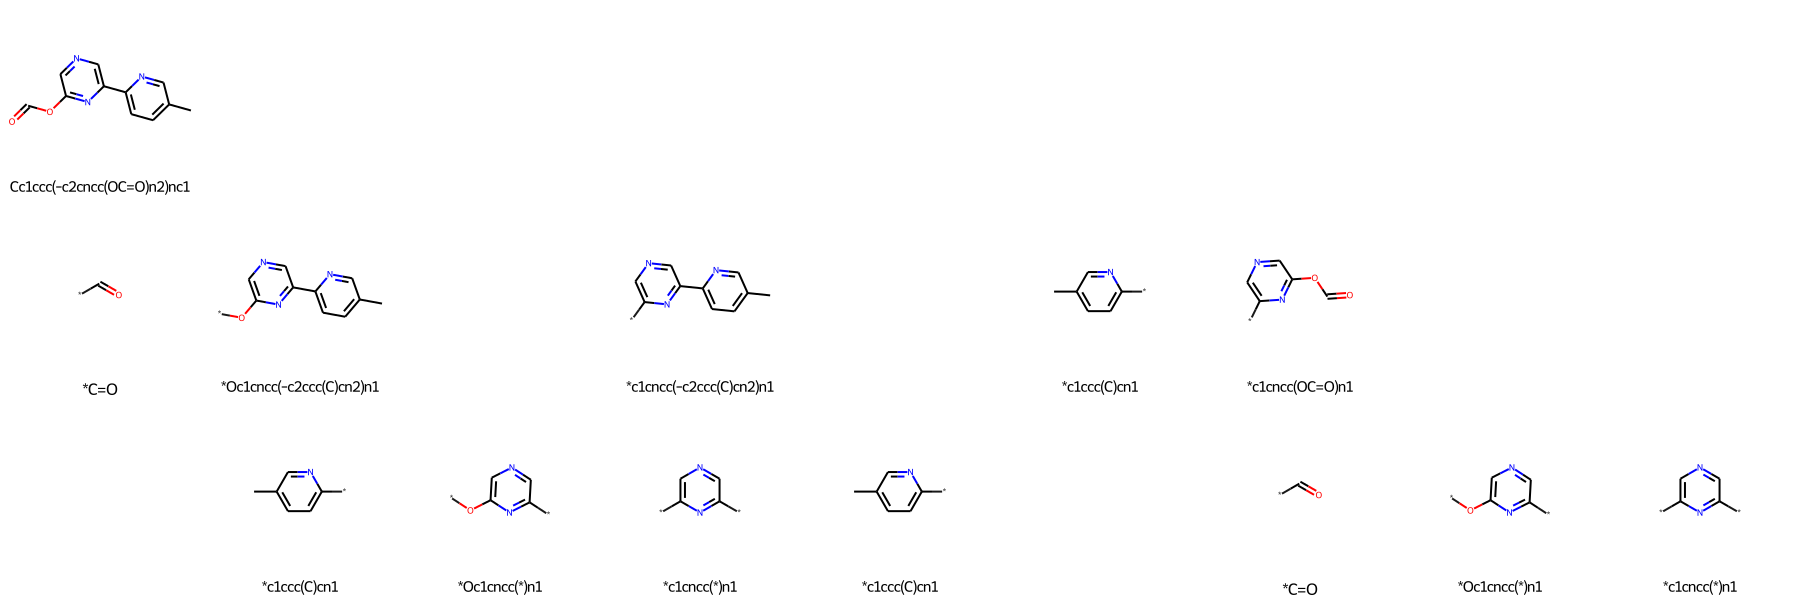

In [16]:
molecule_recap_tree("n1c(OC=O)cncc1-c2ccc(C)cn2")

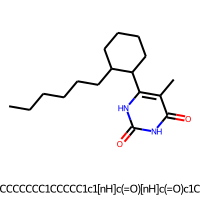

In [17]:
molecule_recap_tree("N1C(=O)NC(=O)C(C)=C1-C1CCCCC1-CCCCCC")

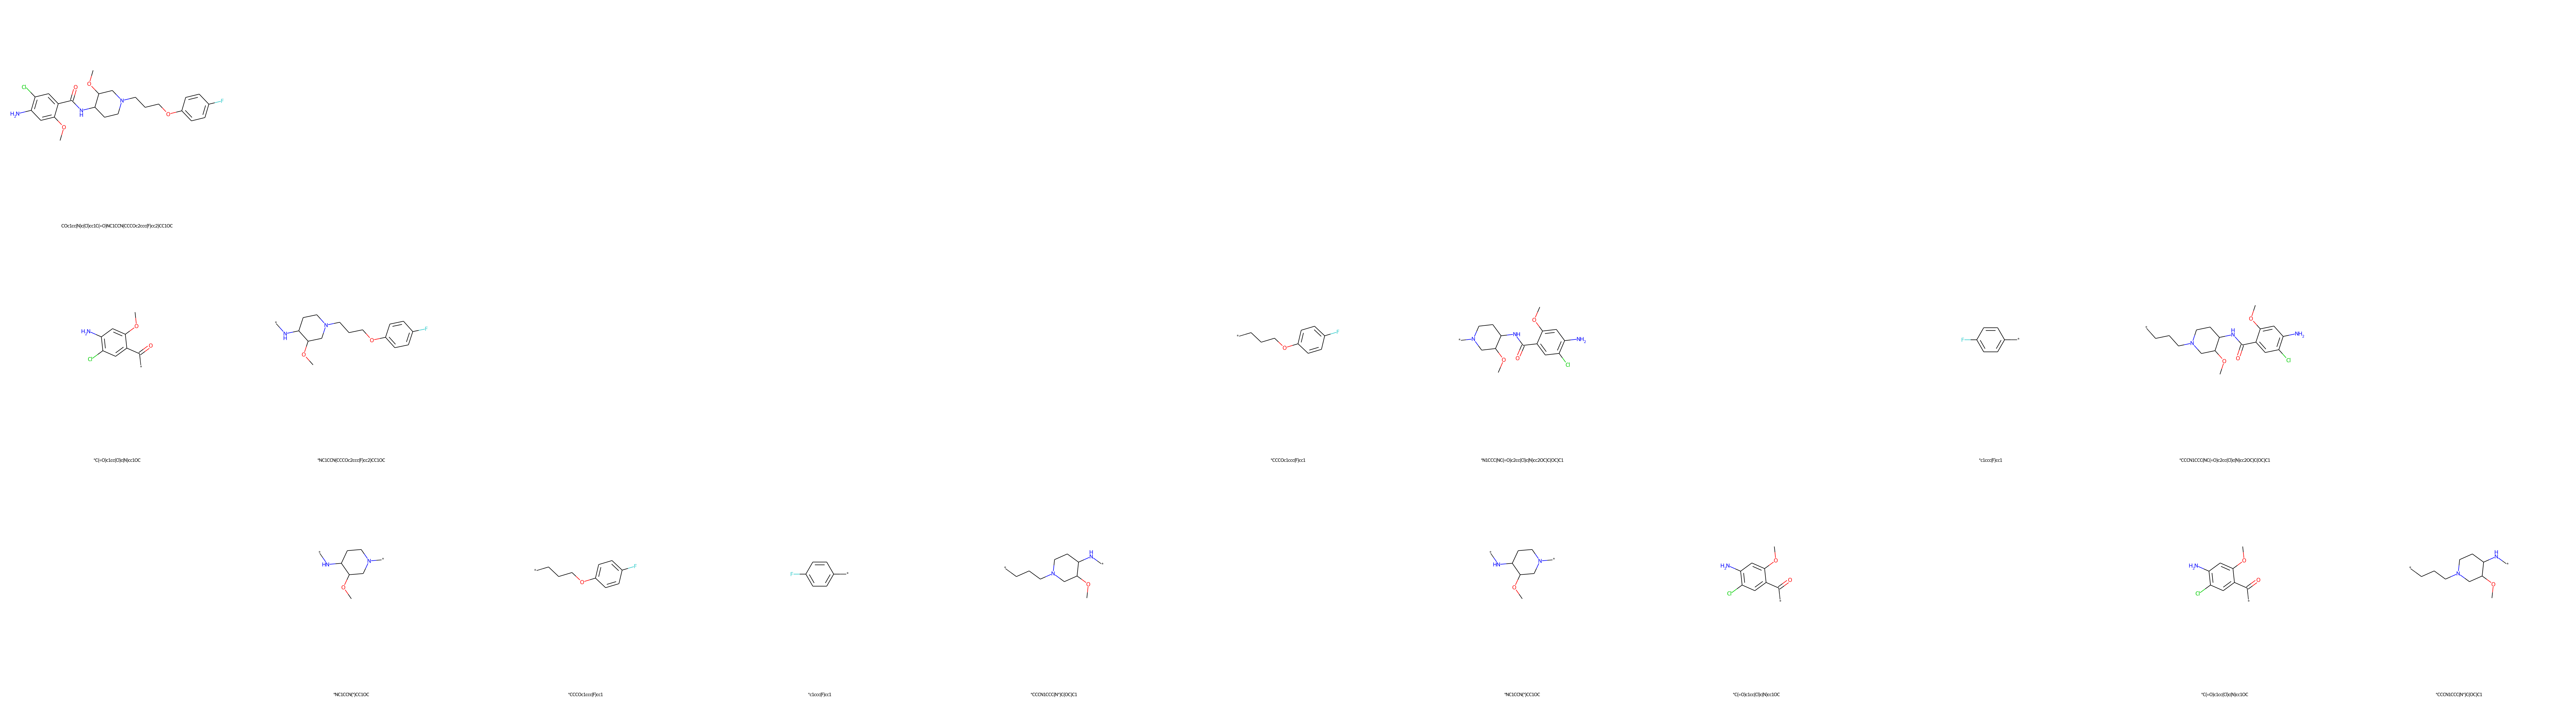

In [18]:
molecule_recap_tree("Clc1cc(c(OC)cc1N)C(=O)NC3CCN(CCCOc2ccc(F)cc2)CC3OC", subImgSize=(800, 800))